In [15]:
from glob import glob
import os
import itertools
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import ImageGrid, make_axes_locatable, host_subplot
import matplotlib.ticker as ticker
from matplotlib.collections import Collection, LineCollection
from matplotlib.artist import allow_rasterization
from matplotlib.font_manager import FontProperties
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.dates as md
import matplotlib.ticker as ticker
from metpy.plots import ctables
#from pyPIPS import disdrometer_module as dis
from pyPIPS import pips_io as pipsio
from pyPIPS import timemodule as tm
from pyPIPS.utils import mtokm, getTimeWindow
from pyPIPS import plotmodule as pm
from pyPIPS import PIPS as pips
from itertools import cycle
import netCDF4 as netcdf
from datetime import datetime, timedelta
import pandas as pd
import xarray as xr
from skimage.restoration import unwrap_phase
import skimage.feature as SF
import numpy.ma as ma
from scipy import ndimage, interpolate
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# global constants, etc.
from scipy.constants import c

# Function definitions

# Based on Robin's code

# Some small functions needed throughout
# Source: 
# https://stackoverflow.com/questions/32237862/find-the-closest-date-to-a-given-date
def nearest(items, pivot):
    """ Finds closest object to 'pivot' in list 'items' """
    return min(items, key=lambda x: abs(x - pivot))

# This function formatter will replace integers with target names
formatter = plt.FuncFormatter(lambda val, loc: categories[val+1])

# My favorite blue-to-red colormap    
cdict1 = {'red':  ((0.0, 0.0, 0.0),
                   (0.3, 0.0, 0.0),
                   (0.5, 1.0, 1.0),
                   (0.7, 0.9, 0.9),
                   (1.0, 0.4, 0.4)),

         'green': ((0.0, 0.0, 0.0),
                   (0.3, 0.0, 0.0),
                   (0.5, 1.0, 1.0),
                   (0.7, 0.0, 0.0),
                   (1.0, 0.0, 0.0)),

         'blue':  ((0.0, 0.4, 0.4),
                   (0.3, 0.9, 0.9),
                   (0.5, 1.0, 1.0),
                   (0.7, 0.0, 0.0),
                   (1.0, 0.0, 0.0))
        }
blue_red1 = LinearSegmentedColormap('BlueRed1', cdict1)

# Custom black-blue-red colormap for hydrometeor classification
hydroclass3 = LinearSegmentedColormap.from_list('hydroclass3', \
                                                [(1, 0, 0), (0, 0, 1), (1, 1, 1)], N=3)

# Colormap for reflectivity that goes to blue instead of black
plasma_white = LinearSegmentedColormap.from_list('plasma_white', \
                                                 ['white','purple','red','yellow'], \
                                                 N=256)


def read_fmcw_xarray(filename):
    """Reads an FMCW netCDF file into an xarray DataSet"""
    
    fmcw_dataset = xr.open_dataset(filename)
    # Rename a couple of the variables to the same name as the dimensions
    # and assign them as coordinates
    fmcw_dataset = fmcw_dataset.rename({'secs': 'time', 'gate': 'height'})
    fmcw_dataset = fmcw_dataset.set_coords(['time', 'height'])
    
    # Fix the 'units' attribute of the new time coordinate so that it can be
    # decoded into datetime objects
    fmcw_dataset['time'].attrs['units'] = fmcw_dataset['time'].attrs.pop('Units')
    fmcw_dataset['time'].attrs['units'] = 'seconds since 1-1-1970'
    fmcw_dataset = xr.decode_cf(fmcw_dataset)
    
    fmcw_dataset['Ze'] = fmcw_dataset['Ze']/10.
    fmcw_dataset['snr'] = fmcw_dataset['snr']/10.
    
    # Add new Wavelength and Nyquist velocity attributes
    fmcw_dataset.attrs['Wavelength'] = c/fmcw_dataset.Frequency
    fmcw_dataset.attrs['Vmax'] = fmcw_dataset.PRF * fmcw_dataset.Wavelength / 4.

    return fmcw_dataset


def read_fmcw(filename):
    """
    Reads basic (moment) variables from a UMass FMCW NetCDF file.
    
    Input: 
        fileName : string
           Name of the UMass FMCW data NetCDF file
    Output: 
        A dictionary with the following arrays keyed by the array name:
        
        height : array
            Height (m AGL)
        vbins : array
            Spectral Velocity Bins (m/s)
        UTCtime : array
            Time in UTC (24-hr)
        Ze : array
            Logarithmic reflectivity factor (dBZ)
        vel : array
            Mean Radial Velocity (m/s)
        wid : array
            Spectrum Width (m/s)
        snr : array
            Signal-to-noise ratio (dB)
        PRF : float
            Pulse repetition frequency (Hz)
        Frequency : float
            Radar frequency (Hz)
        Wavelength : float
            Radar wavelength (m)
        Vmax : float
            Maximum unambiguous (Nyquist) velocity (m/s)
    """
    data = netcdf.Dataset(filename, "r")
    height = data.variables['height'][:]
    vbins = data.variables['vbins'][:]
    secs = data.variables['secs'][:]
    Ze = data.variables['Ze'][:]/10.
    ZeName = data.variables['Ze'].Name
    vel = data.variables['vel'][:]
    velName = data.variables['vel'].Name
    wid = data.variables['wid'][:]
    widName = data.variables['wid'].Name
    snr = data.variables['snr'][:]/10.
    snrName = data.variables['snr'].Name
    PRF = data.PRF
    Frequency = data.Frequency
    
    data.close()
    # Convert frequency to wavelength
    Wavelength = c/Frequency
    # Nyquist velocity
    Vmax = PRF * Wavelength / 4.    
    # Convert secs (number of seconds since epoch) into UTC time
    UTCtime = []
    for s in secs:
        UTCtime.append(datetime(1970, 1, 1, 0, 0, 0) + timedelta(0, int(s)))
    UTCtime = np.array(UTCtime)
    return {'height': height, 'vbins': vbins, 'UTCtime': UTCtime, 'Ze': (ZeName, Ze), 
            'vel': (velName, vel), 'wid': (widName, wid), 'snr': (snrName, snr), 
            'PRF': PRF, 'Frequency': Frequency, 'Wavelength': Wavelength, 'Vmax': Vmax}


def get_fmcw_filepaths(basedir, starttimestring, endtimestring, subdirs=False):
    """Gets a list of FMCW file paths given a base directory and a starttime and endtime"""
    timeformat = '%Y%m%d%H%M'
    
    starttime = datetime.strptime(starttimestring, timeformat)
    endtime = datetime.strptime(endtimestring, timeformat)
    
    delta = endtime - starttime
    totalhours = int(delta.days * 24 + delta.seconds/3600)

    delta_day_bounds = (endtime.date() - starttime.date()).days

    datetimerange = [starttime + timedelta(hours=x) for x in range(0, totalhours + 1)]
    daterange = [starttime.date() + timedelta(days=x) for x in range(0, delta_day_bounds + 1)]

    if subdirs:
        subdir_template = "{:02d}{:02d}"
        subdirs = [subdir_template.format(x.month, x.day) for x in daterange]


    filename_format = 'S{:04d}{:02d}{:02d}T{:02d}' 
    filename_templates = [filename_format.format(x.year, x.month, x.day, x.hour) for x in datetimerange]
    
    ncfiles2d = []
    if subdirs:
        for subdir in subdirs:
            absdir = os.path.join(fmcw_data_dir, subdir)
            ncfiles2d.append(glob(absdir + '/*nc'))
        ncfiles = list(itertools.chain.from_iterable(ncfiles2d))
    else:
        ncfiles = glob(fmcw_data_dir + '/*nc')

    pathlist = [f for f in ncfiles if any(m in f for m in filename_templates)]

    return pathlist


# def combine_fmcw_xr_datasets(datasets):
#     """Combines dictionaries containing FMCW data read in from multiple files into a single dictionary"""
    
#     combined_dict = {}
#     for data_dict in data_dictlist:
#         for varname in data_dict:
            


def plot_fmcw_4panel(fileName):
    """Basic four-panel plot of file contents."""
    
    data_dict = read_fmcw(fileName)
    
#     height, vbins, UTCtime, Ze, vel, wid, snr, PRF, Frequency, Wavelength, Vmax, \
#         ZeName, velName, widName, snrName = readfmcw_more(fileName)
    
    height = data_dict['height']
    Vmax = data_dict['Vmax']
    UTCtime = data_dict['UTCtime']
    ZeName, Ze = data_dict['Ze']
    velName, vel = data_dict['vel']
    widName, wid = data_dict['wid']
    snrName, snr = data_dict['snr']
    
    if fileName[-18:-14] == "2017": Vmax = 7.3  # 2017 data were collected with a 
    # solid state amplifier that had a larger Nyquist interval than the default 
    # +/-4.9 m/s.
    
    # 4-panel plot of output
    fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
    fig.set_size_inches(8.5,4.75)
    fig.subplots_adjust(bottom=0.15) # Keeps xlabel from getting chopped off
    fig.subplots_adjust(wspace=0.05) # Expand subplots slightly in the horizontal
    
    # Reflectivity (Ze)
    m1 = ax[0, 0].pcolormesh(UTCtime, height/1000., Ze.T,cmap=plasma_white, \
                             vmin=-30., vmax=30.)
    ax[0, 0].set_title("(a) " + ZeName + " (dBZ)")
    ax[0, 0].set_ylim(np.min(height), np.max(height))
    ax[0, 0].xaxis.set_major_locator(md.MinuteLocator(byminute=range(0, 60, 10)))
    ax[0, 0].xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
    ax[0, 0].yaxis.set_major_formatter()
    #plt.xticks(rotation=30)
    #ax[0, 0].set_xlabel("Time (UTC)")
    ax[0, 0].set_ylabel("Height (km AGL)")
    plt.colorbar(m1,ax=ax[0, 0])
    
    # Doppler (vertical) velocity (vel)
    m2 = ax[0, 1].pcolormesh(UTCtime,height/1000., vel.T, cmap=cm.RdBu_r, \
                             vmin=-1.*np.ceil(Vmax), vmax=np.ceil(Vmax))
    ax[0, 1].set_title("(b) " + velName + r" (m s$^{-1}$)")
    ax[0, 1].set_ylim(np.min(height/1000.),np.max(height/1000.))
    ax[0, 1].xaxis.set_major_locator(md.MinuteLocator(byminute=range(0, 60, 10)))
    ax[0, 1].xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
    #plt.xticks(rotation=30)
    #ax[0, 1].set_xlabel("Time (UTC)")
    #ax[0, 1].set_ylabel("Height (km AGL)")
    plt.colorbar(m2,ax=ax[0, 1])
    
    # Spectrum width (wid)
    m3 = ax[1, 0].pcolormesh(UTCtime, height/1000., wid.T, cmap=cm.BuPu, \
                             vmin=0., vmax=5.)
    ax[1, 0].set_title("(c) " + widName + r" (m s$^{-1}$)")
    ax[1, 0].set_ylim(np.min(height/1000.),np.max(height/1000.))
    ax[1, 0].xaxis.set_major_locator(md.MinuteLocator(byminute=range(0, 60, 10)))
    ax[1, 0].xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
    #plt.xticks(rotation=30)
    ax[1, 0].set_xlabel("Time (UTC)")
    ax[1, 0].set_ylabel("Height (km AGL)")
    plt.colorbar(m3,ax=ax[1, 0])
    
    # SNR (db)
    m4 = ax[1, 1].pcolormesh(UTCtime, height/1000., snr.T, cmap=cm.viridis, \
                             vmin=-20., vmax=30.)
    ax[1, 1].set_title("(d) " + snrName + " (dB)")
    ax[1, 1].set_ylim(np.min(height/1000.), np.max(height/1000.))
    ax[1, 1].xaxis.set_major_locator(md.MinuteLocator(byminute=range(0, 60, 10)))
    ax[1, 1].xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
    #plt.xticks(rotation=30)
    ax[1, 1].set_xlabel("Time (UTC)")
    #ax[1, 1].set_ylabel("Height (km AGL)")
    plt.colorbar(m4,ax=ax[1, 1])
    
    plt.savefig(fileName[-19:-3] + "_4panel.png",dpi=300)
    
    # Need to have ImageMagick installed on your system for the following command to
    # work. It deletes white space around the edges of the plot (thus saving disk space).
    #os.system("convert -trim " + fileName[-19:-3] + "_4panel.png " + \
    #          fileName[-19:-3] + "_4panel.png")
    
def plot_fmcw_4panel_xarray(dataset, figname='FMCW'):
    """Basic four-panel plot of file contents."""
    
#     height, vbins, UTCtime, Ze, vel, wid, snr, PRF, Frequency, Wavelength, Vmax, \
#         ZeName, velName, widName, snrName = readfmcw_more(fileName)
    if dataset['time'].dt.year[0].item() == 2017: Vmax = 7.3  # 2017 data were collected with a 
    # solid state amplifier that had a larger Nyquist interval than the default 
    # +/-4.9 m/s.
        
    # 4-panel plot of output
    fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
    fig.set_size_inches(8.5,4.75)
    fig.subplots_adjust(bottom=0.15) # Keeps xlabel from getting chopped off
    fig.subplots_adjust(wspace=0.05) # Expand subplots slightly in the horizontal
    
    # Reflectivity (Ze)
#     m1 = ax[0, 0].pcolormesh(UTCtime, height/1000., Ze.T,cmap=plasma_white, \
#                              vmin=-30., vmax=30.)

    m1 = dataset['Ze'].plot(x='time', y='height', ax=ax[0, 0], cmap=plasma_white, vmin=-30., vmax=30.)
    
    ax[0, 0].set_title("(a) " + dataset['Ze'].name + " (dBZ)")
    ax[0, 0].set_ylim(dataset['height'].min(), dataset['height'].max())
    # ax[0, 0].xaxis.set_major_locator(md.MinuteLocator(byminute=range(0, 60, 10)))
    # ax[0, 0].xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
    ax[0, 0].yaxis.set_major_formatter(ticker.FuncFormatter(mtokm))
    #plt.xticks(rotation=30)
    #ax[0, 0].set_xlabel("Time (UTC)")
    ax[0, 0].set_ylabel("Height (km AGL)")
    # plt.colorbar(m1,ax=ax[0, 0])
    
    # Dealiased Doppler (vertical) velocity (vel_da)
    
    m2 = dataset['vel_da'].plot(x='time', y='height', ax=ax[0, 1], cmap=cm.RdBu_r, 
                                vmin=-2.*np.ceil(dataset.Vmax), vmax=2.*np.ceil(dataset.Vmax))
    
#     m2 = ax[0, 1].pcolormesh(UTCtime,height/1000., vel.T, cmap=cm.RdBu_r, \
#                              vmin=-1.*np.ceil(Vmax), vmax=np.ceil(Vmax))
    
    ax[0, 1].set_title("(b) " + dataset['vel_da'].name + r" (m s$^{-1}$)")
    ax[0, 1].set_ylim(dataset['height'].min(), dataset['height'].max())
    # ax[0, 1].xaxis.set_major_locator(md.MinuteLocator(byminute=range(0, 60, 10)))
    # ax[0, 1].xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
    ax[0, 1].yaxis.set_major_formatter(ticker.FuncFormatter(mtokm))
    #plt.xticks(rotation=30)
    #ax[0, 1].set_xlabel("Time (UTC)")
    #ax[0, 1].set_ylabel("Height (km AGL)")
    # plt.colorbar(m2,ax=ax[0, 1])
    
    # Spectrum width (wid)
    
    m3 = dataset['wid'].plot(x='time', y='height', ax=ax[1, 0], cmap=cm.BuPu, 
                             vmin=0., vmax=5.)
    
#     m3 = ax[1, 0].pcolormesh(UTCtime, height/1000., wid.T, cmap=cm.BuPu, \
#                              vmin=0., vmax=5.)
    ax[1, 0].set_title("(c) " + dataset['wid'].name + r" (m s$^{-1}$)")
    ax[1, 0].set_ylim(dataset['height'].min(), dataset['height'].max())
    # ax[1, 0].xaxis.set_major_locator(md.MinuteLocator(byminute=range(0, 60, 10)))
    # ax[1, 0].xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
    ax[1, 0].yaxis.set_major_formatter(ticker.FuncFormatter(mtokm))
    #plt.xticks(rotation=30)
    ax[1, 0].set_xlabel("Time (UTC)")
    ax[1, 0].set_ylabel("Height (km AGL)")
    # plt.colorbar(m3,ax=ax[1, 0])
    
    # SNR (db)
    
    m4 = dataset['snr'].plot(x='time', y='height', ax=ax[1, 1], cmap=cm.viridis, 
                             vmin=-20., vmax=30.)
    
#     m4 = ax[1, 1].pcolormesh(UTCtime, height/1000., snr.T, cmap=cm.viridis, \
#                              vmin=-20., vmax=30.)
    ax[1, 1].set_title("(d) " + dataset['snr'].name + " (dB)")
    ax[1, 1].set_ylim(dataset['height'].min(), dataset['height'].max())
    # ax[1, 1].xaxis.set_major_locator(md.MinuteLocator(byminute=range(0, 60, 10)))
    # ax[1, 1].xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
    ax[1, 1].yaxis.set_major_formatter(ticker.FuncFormatter(mtokm))
    #plt.xticks(rotation=30)
    ax[1, 1].set_xlabel("Time (UTC)")
    #ax[1, 1].set_ylabel("Height (km AGL)")
    # plt.colorbar(m4,ax=ax[1, 1])
    
    figname = figname + "_4panel.png"
    plt.savefig(figname, dpi=300)
    
    # Need to have ImageMagick installed on your system for the following command to
    # work. It deletes white space around the edges of the plot (thus saving disk space).
    try:
        os.system("convert -trim " + figname + " " + figname)
    except OSError:
        print("Can't find ImageMagick! No conversion will be done.")
    
def linear_texture_1d(image, n, axis=0, boundary_condition='reflect'):
    """
    Compute the 1D linear texture of an image given an n x ! window.
    This will only do the texture along one axis (useful for vertically
    pointing radar data)

    Parameters
    ----------
    image: 2D array of floats
        The image to calculate the texture of
    n: int
        The size of the window to calculate the standard deviation
        over.
    axis:
        Axis to calculate standard deviation over.
    boundary_condition:
        This determines how the edges are handled when calculating texture.
        'reflect' = 

    Returns
    -------
    std_dev: 2D array of floats (n x n)
        The linear texture of the image

    Written by Bobby Jackson, Argonne National Laboratory, Feb 2018
    Tweaked by Robin Tanamachi, Purdue University, Feb 2018
    """

    mean_kernel = np.ones(n)/float(n)
    sum_kernel = np.ones(n)
    image = image.astype(float)
    image_squared = image**2
    sum_squares = ndimage.convolve1d(
        image_squared, sum_kernel, axis=axis, mode='reflect')
    sum_array = ndimage.convolve1d(
        image, sum_kernel, axis=axis, mode='reflect')
    #print(sum_array)

    variance = 1.0/float(n+1)*(sum_squares.astype(float) - sum_array.astype(float)**2/float(n))
    #print(variance)
    #print(np.max(variance),np.min(variance))

    return np.sqrt(variance)


def unwrap_fmcw_vel(vel, Vmax, wid_texture, snr, snrThreshold = -50.):
    """
    Dealiases Doppler velocities using the unwrap_phase method of scikit-image. The
    fields snr and wid_texture are combined to create a mask for the raw Doppler 
    velocities; masked elements are not dealiased.
    
    Input:
        vel : 2D array of floats
            Doppler velocity array (vel) from an FMCW NetCDF file. (m/s)
        Vmax : float
            Maximum unambiguous velocity of the radar system. (m/s)
        wid_texture : 2D array of floats
            Output from linear_texture_1d applied to the wid field, used to construct
            a mask for the dealiasing. Masked elements won't be dealiased. (m/s)
        snr : 2D array of floats
            Signal-to-noise ratio array (snr) from an FMCW NetCDF file. (dB)
        snrThreshold : float
            Mask vel on snr below this value (in dB). Masked elements won't be 
            dealiased.
    Output:
        vel_masked_unwrap : 2D array of floats (masked)
            Dealiased Doppler velocity array of the same size and shape as vel. (m/s)
    """
    wid_textureThreshold = 0.2  # Determined through experimentation. Anything above this
                                # value is likely to be nonmeteorological or attenuated.
    # Scale velocities to phase in range (-pi,pi]. Required by unwrap_phase.
    psi = vel / Vmax * np.pi
    # Combine SNR threshold and spectrum width texture threshold into a mask.
    # Note that the spectrum width texture mask is dilated by 1 pixel to mitigate edge 
    # effects.
    psi_masked = ma.masked_array(data = psi, mask = \
        np.any( np.dstack( [snr<=snrThreshold, \
        ndimage.morphology.binary_dilation( wid_texture > 0.2 )] ), \
        axis=2) )
    psi_masked_unwrap = unwrap_phase(psi_masked)
    # Convert phase back to velocity
    vel_masked_unwrap = psi_masked_unwrap * Vmax / np.pi
    
    return vel_masked_unwrap

def dealias(dataset, texture_kernel = 3):
    """Given an FMCW xarray DataSet, dealias the velocity data and create a new variable to store it"""
    # texture_kernel must be an odd, positive integer
    # Calculate spectrum width texture
    wid_texture = linear_texture_1d(dataset['wid'], texture_kernel, axis=1)
    # Mask the velocity on spectrum width and SNR, then dealias
    vel_masked_unwrap = unwrap_fmcw_vel(dataset['vel'], dataset.Vmax, wid_texture, dataset['snr'])
    dataset['vel_da'] = xr.DataArray(data=vel_masked_unwrap, dims=('time', 'height'), 
                                     attrs = {'name': 'Mean Radial Velocity (dealiased)', 'units': 'm/s'} )

In [3]:
fmcw_data_dir = '/Users/dawson29/pyPIPS_work/VORTEXSE/PIPS2A_FMCW/fmcw_data'
starttimestring = '201704302000'
endtimestring = '201704302359'

filepaths = get_fmcw_filepaths(fmcw_data_dir, starttimestring, endtimestring, subdirs=False)
print(filepaths)

['/Users/dawson29/pyPIPS_work/VORTEXSE/PIPS2A_FMCW/fmcw_data/S20170430T220104.nc', '/Users/dawson29/pyPIPS_work/VORTEXSE/PIPS2A_FMCW/fmcw_data/S20170430T200333.nc', '/Users/dawson29/pyPIPS_work/VORTEXSE/PIPS2A_FMCW/fmcw_data/S20170430T230458.nc', '/Users/dawson29/pyPIPS_work/VORTEXSE/PIPS2A_FMCW/fmcw_data/S20170430T210037.nc']


In [4]:
datasets = []
for file in filepaths:
    print("Reading " + file)
    datasets.append(read_fmcw_xarray(file))

Reading /Users/dawson29/pyPIPS_work/VORTEXSE/PIPS2A_FMCW/fmcw_data/S20170430T220104.nc
Reading /Users/dawson29/pyPIPS_work/VORTEXSE/PIPS2A_FMCW/fmcw_data/S20170430T200333.nc
Reading /Users/dawson29/pyPIPS_work/VORTEXSE/PIPS2A_FMCW/fmcw_data/S20170430T230458.nc
Reading /Users/dawson29/pyPIPS_work/VORTEXSE/PIPS2A_FMCW/fmcw_data/S20170430T210037.nc


In [7]:
# Why does the following remove the global attributes? TODO: try "keep_attrs = True" next time.
fmcw_merged_dataset = xr.combine_by_coords(datasets)
# Restore the global attributes
fmcw_merged_dataset.attrs = datasets[0].attrs

In [8]:
print(datasets[0])

<xarray.Dataset>
Dimensions:  (height: 1024, time: 300, vels: 256)
Coordinates:
  * height   (height) float32 1.0 5.0 10.0 15.0 ... 5100.0 5105.0 5110.0 5115.0
  * time     (time) datetime64[ns] 2017-04-30T22:01:16 ... 2017-04-30T23:04:51
Dimensions without coordinates: vels
Data variables:
    vbins    (vels) float32 ...
    Zef      (time, height, vels) int16 ...
    sf       (time, height, vels) int16 ...
    sn       (time, height) int16 ...
    sff      (time, height, vels) int16 ...
    snr      (time, height) float64 14.1 12.4 1.2 -11.5 -1.2 ... 5.4 5.5 5.5 6.2
    Ze       (time, height) float64 -67.8 -55.5 -60.8 -70.1 ... -2.3 -2.3 -1.6
    vel      (time, height) float32 ...
    wid      (time, height) float32 ...
Attributes:
    NetCDFRevision:  UMass MIRSL FMCW V1.0
    RadarName:       UMa-FMCW
    PRF:             287.224
    Frequency:       2945000000.0
    Latitude:        34.6872
    Longitude:       -86.005
    Wavelength:      0.10179710170289118
    Vmax:          

In [9]:
# Dealias
dealias(fmcw_merged_dataset)

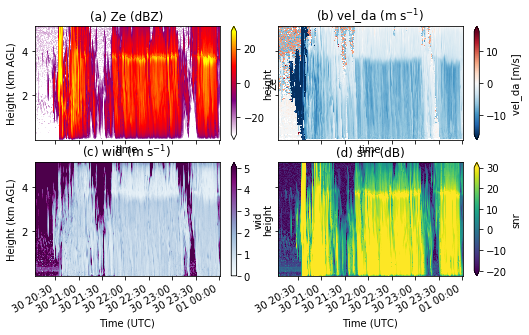

In [10]:
# %matplotlib inline
# plt.rcParams["figure.figsize"] = (20,10)
plot_fmcw_4panel_xarray(fmcw_merged_dataset)

In [14]:
PIPS_data_dir = '/Users/dawson29/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/2017/PIPS/PIPS2A_FMCW/'
PIPS_data_filename = 'PIPS2A_FMCW_043017.txt'
PIPS_data_file_path = os.path.join(PIPS_data_dir, PIPS_data_filename)

conv_df, parsivel_df, vd_matrix_da = pipsio.read_PIPS(PIPS_data_file_path,
                                                      starttimestamp=starttimestring+'00',
                                                      stoptimestamp=endtimestring+'00')

GPS time: Sun Apr 30 00:00:04 2017, Logger time: Sun Apr 30 00:00:01 2017
GPS Offset: 0:00:03


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/xarray/core/computation.py:601: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/ipykernel_launcher.py:74: RuntimeWarning: divide by zero encountered in log10


(32, 1272)
<xarray.DataArray 'height' ()>
array(250.)
Coordinates:
    height   float64 250.0
<xarray.DataArray 'Ze' (time: 1112)>
array([-38.5, -38.4, -42.8, ..., -16.7, -19.6, -21.7])
Coordinates:
    height   float64 250.0
  * time     (time) datetime64[ns] 2017-04-30T20:03:45 ... 2017-05-01T00:00:46


No handles with labels found to put in legend.


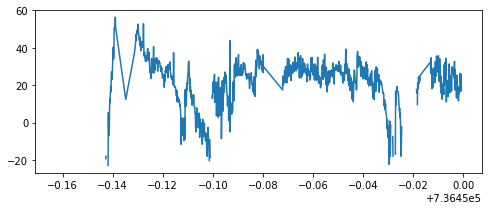

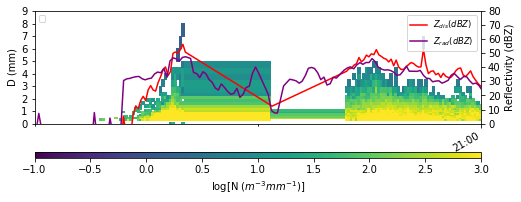

In [26]:
import pyPIPS.parsivel_params as pp
import pyPIPS.polarimetric as dp
min_diameter = pp.parsivel_parameters['min_diameter_bins_mm']
max_diameter = pp.parsivel_parameters['max_diameter_bins_mm']
bin_width = max_diameter - min_diameter
avg_diameter = pp.parsivel_parameters['avg_diameter_bins_mm']
min_fall_bins = pp.parsivel_parameters['min_fallspeed_bins_mps']
max_fall_bins = pp.parsivel_parameters['max_fallspeed_bins_mps']
avg_fall_bins = pp.parsivel_parameters['avg_fallspeed_bins_mps']

conv_df = pips.calc_thermo(conv_df)
# empirical_fallspeed = pips.calc_empirical_fallspeed(avg_diameter)
fallspeed_spectrum = pips.calc_fallspeed_spectrum(avg_diameter, avg_fall_bins, correct_rho=True,
                                                  rho=conv_df['rho'])
vd_matrix_da = vd_matrix_da.where(vd_matrix_da > 0.0)
ND = pips.calc_ND(vd_matrix_da, fallspeed_spectrum, 10.)
ND = ND.T
logND = np.log10(ND)
logND = 

PSD_datetimes = pips.get_PSD_datetimes(vd_matrix_da)
PSD_datetimes_dict = pips.get_PSD_time_bins(PSD_datetimes)

PSD_edgetimes = md.date2num(PSD_datetimes_dict['PSD_datetimes_edges'])
PSD_centertimes = md.date2num(PSD_datetimes_dict['PSD_datetimes_centers'])

# ND = PIPS_dict['ND'].T
# logND = ma.log10(ND)
# DSD_index = PIPS_dict['DSD_index']
# DSD_interval = PIPS_dict['DSD_interval']
# DSD_interval_td = timedelta(seconds=DSD_interval)
# DSD_halfinterval_td = timedelta(seconds=DSD_interval / 2.)

# Determine start and end times/indices for analysis
# PSDtimestamps = PIPS_dict['PSDtimestamps']
# PSDtimestampsnums = md.date2num(PSDtimestamps)

#     plotstarttime = starttime
#     plotstoptime = stoptime

# pstartindex, pstopindex = getTimeWindow(starttimestring, endtimestring, PSDtimestampsnums)

# pstarttime = PSDtimestampsnums[pstartindex]
# pstoptime = PSDtimestampsnums[pstopindex]

# plotstarttime = pstarttime
# plotstoptime = pstoptime

# PSDtimestamps_edge = [x - DSD_interval_td for x in PSDtimestamps]
# # Add an extra 10 sec for the last time bin boundary
# PSDtimestamps_edge.append(PSDtimestamps_edge[-1] + DSD_interval_td)
# PSDtimestamps_avg = [x - DSD_halfinterval_td for x in PSDtimestamps]
# PSDstarttimes = md.date2num(PSDtimestamps_edge[pstartindex:pstopindex + 1])
# PSDmidtimes = md.date2num(PSDtimestamps_avg[pstartindex:pstopindex + 1])

scattfile = '/Users/dawson29/Projects/pyPIPS/tmatrix/FMCW/SCTT_RAIN_fw100.dat'
# Observed DSD: TODO, need to make ND, ND_expDSD, and ND_gamDSD have consistent units!
dualpol_dis = dp.calpolrain(15.0, scattfile, ND, bin_width)
dis_ref = dualpol_dis.get('dBZ', np.empty((0)))
logND_plot = logND
disvars = {'min_diameter': min_diameter, 'PSDstarttimes': PSD_edgetimes,
           'PSDmidtimes': PSD_centertimes, 'logND': logND_plot}
# disvars['dBZ'] = dis_ref[pstartindex:pstopindex + 1]

# Quick and dirty rayleigh scattering approximation

M6 = []
print(ND.shape)
for t in range(ND.shape[-1]):
    temp_M6 = ((avg_diameter[:] / 1000.)**6.) * (1000. * ND[:, t]) * bin_width[:] / 1000.
    temp_M6 = np.nansum(temp_M6)
    M6.append(temp_M6)

M6 = np.array(M6, dtype=np.float64)
refl_disd = 10.0 * np.log10(1e18 * M6)
disvars['dBZ'] = refl_disd

fig, ax = plt.subplots(figsize=(8, 3))

ax.plot(PSD_centertimes, disvars['dBZ'])

radz = 250. # (m) Height of FMCW gate to plot
radzindex = int(radz/5.)

plotx_rad = fmcw_merged_dataset['time'].values
dBZ_D_plt = fmcw_merged_dataset['Ze'].values[:, radzindex] + 10.**(2.*7.3/10.)


print(fmcw_merged_dataset['height'][radzindex])
print(fmcw_merged_dataset['Ze'][:, radzindex])

# fmcw_merged_dataset['Ze'][:, radzindex].plot()

# print(dBZ_D_plt)

radvars = {'radmidtimes': plotx_rad, 'dBZ': dBZ_D_plt}

# Prepare axis parameters
# timelimits = [md.date2num(datetime.strptime(starttimestring, tm.timefmt3)),
#               md.date2num(datetime.strptime(endtimestring, tm.timefmt3))]
timelimits = [md.date2num(datetime.strptime('20170430203000', tm.timefmt3)),
              md.date2num(datetime.strptime('20170430210000', tm.timefmt3))]
diamlimits = [0.0, 9.0]
diamytick = 1.0

locator = md.HourLocator(interval=1)
minorlocator = md.MinuteLocator(byminute=[0,15,30,45])
# minorlocator = md.HourLocator(interval=1)
#dateformat = '%d/%H'
dateformat = '%H:%M'
formatter = md.DateFormatter(dateformat)
axparams = {'majorxlocator': locator, 'majorxformatter': formatter,
            'minorxlocator': minorlocator,
            'axeslimits': [timelimits, diamlimits],
            'majorylocator': ticker.MultipleLocator(base=diamytick),
            'axeslabels': [None, 'D (mm)']}

            # Ok, now we should have everything ready to go to plot the meteograms.
            # Let'er rip!
meteogram_image_dir = './'
dis_plot_name = 'PIPS1A_observed'
pm.plotDSDmeteograms(dis_plot_name, meteogram_image_dir,
                     axparams, disvars, radvars.copy(), close_fig=False)